
## Delta GPTs - (Train on 100, 200, 300 and predict the next 20)

* Delta: SI differences
* compare 100 to 200 to 300
* Written to run on GPU
* Long train so best run on GPU
* Next Cast is green line
* Saves Results to text file



## Libraries


In [1]:

##!pip install xgboost
## !pip install matplotlib
## !pip install scikit-learn
## !pip install einops


In [2]:

import pandas as pd
import numpy as np


In [3]:

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [4]:


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import torch
import pandas as pd
import sklearn
import random
import math


In [5]:

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## coefficient of determination 
from sklearn.metrics import r2_score


In [6]:

from einops import rearrange
from math import sqrt, log



## Positional Encoding example


In [7]:

def PositionalEncoding(q_len, d_model, normalize=True):
    pe = torch.zeros(q_len, d_model)
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe



## Read the data


In [8]:

for_RNN_data_CIVS = pd.read_csv('input/RNN_time_DELAYS_2000_PerCast_rcalix.csv')


In [9]:

for_RNN_data_CIVS


,Unnamed: 0,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,...,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,1,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,...,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,2,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,...,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,3,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,...,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,4,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,...,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,5,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,...,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,1379,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,...,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,1380,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,...,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,1381,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,...,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,1382,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,...,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [10]:

cols_list_DF = for_RNN_data_CIVS.columns.values.tolist()
cols_list_DF


['Unnamed: 0',
 'SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']

In [11]:

l_new = ['SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [12]:


l_map_dates = ['SI_f1',
 'Date_Map',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'CNUM',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']




In [13]:

for_RNN_data_CIVS = for_RNN_data_CIVS[l_new]


In [14]:

for_RNN_data_CIVS 


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,...,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,...,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,...,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,...,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,...,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,...,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,...,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,...,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,...,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,...,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0



## The Dates Map


In [15]:

df_Dates_Map = pd.read_csv('input/RC_CNUM_RNN_time_DELAYS_2000_PerCast_rcalix.csv')

df_Dates_Map = df_Dates_Map[ l_map_dates ]

df_Dates_Map


,SI_f1,Date_Map,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,...,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.719500,2022-01-01 00:45:00,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,...,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.710486,2022-01-01 08:43:00,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,...,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0.666106,2022-01-01 10:17:00,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,...,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.675145,2022-01-01 12:40:00,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,...,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.776831,2022-01-01 15:06:00,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,...,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,2021-12-31 13:10:00,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,...,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0.646000,2021-12-31 14:41:00,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,...,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.654667,2021-12-31 16:15:00,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,...,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0.591667,2021-12-31 17:40:00,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,...,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0



## Plots


In [16]:

plt.rcParams["figure.figsize"] = [15, 5]


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

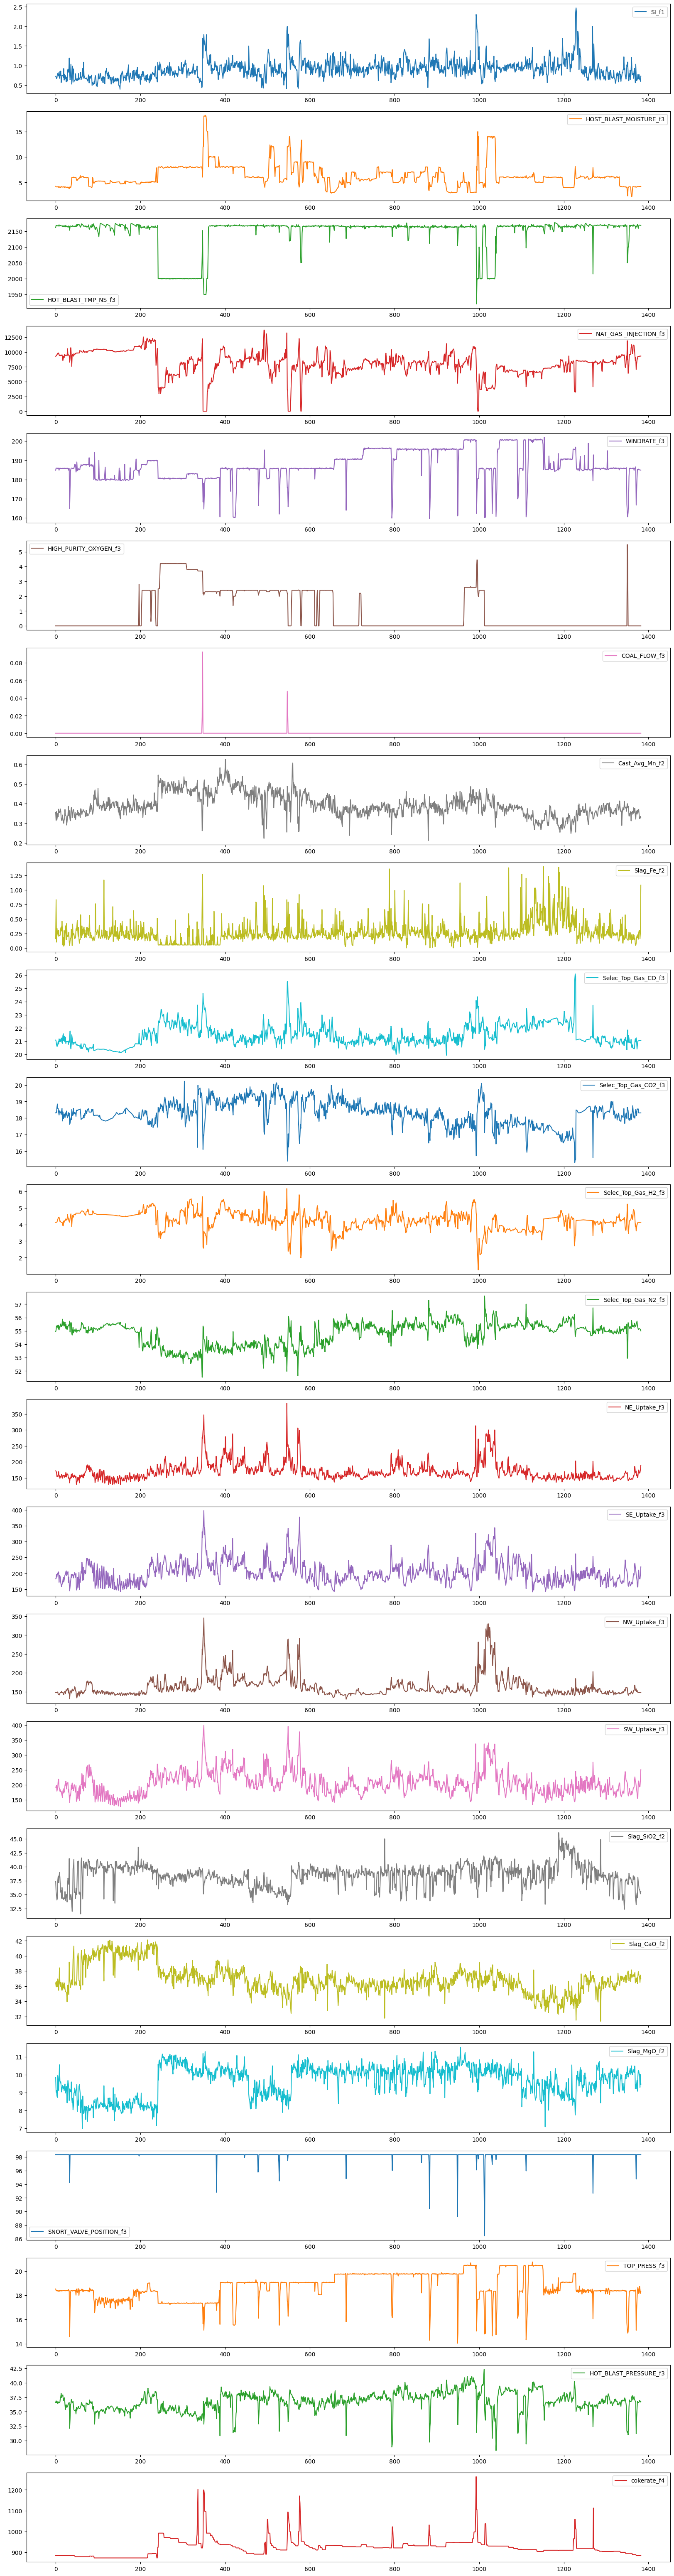

In [17]:

for_RNN_data_CIVS.plot( kind='line', subplots=True, figsize=(20,80),
        sharex=False, sharey=False, legend=True )


In [18]:

print(for_RNN_data_CIVS.shape)


(1383, 24)



## Parameters


In [19]:

pd.options.display.max_columns = None



## Standardize (Scaling)


In [20]:

def standardize_x_scales( data_gpt_pd ):


    data_gpt = torch.tensor(data_gpt_pd.values).float()
        
    epsilon = 0.0001

    print( data_gpt.shape)        
    
    x_means      = data_gpt .mean(0,  keepdim=True)
    x_deviations = data_gpt .std( 0,  keepdim=True) + epsilon

    ## x_train_tr_scaled = (x_train_tr - x_means) / x_deviations
    ## y_test_tr_scaled  = (y_test_tr  - y_means) / y_deviations
    
    return data_gpt, x_means, x_deviations


In [21]:

## x_means      = simple_x_train.mean(0, keepdim=True ) 
## x_deviations = simple_x_train.std( 0, keepdim=True) + epsilon



## Shift and create batches


In [22]:

def get_batch( data_gpt ):
    
    ix = torch.randint(   len(data_gpt) - block_size, (batch_size,)   )

    x  = torch.stack(    [  data_gpt[   i   : i+block_size    ]   for i in ix ]    ) 
    y  = torch.stack(    [  data_gpt[   i+1 : i+1+block_size  ]   for i in ix ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y



## NN Architectures


In [23]:

class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        
        self.key   = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.query = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.value = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]

        tril_def = torch.tril( torch.ones(block_size, block_size) )  ## [40, 40]
        
        self.register_buffer(
                  'tril', 
                  tril_def
               )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        B, T, E = x.shape   ## [batch_size, 40, 512] or [B, 15, 512]
        
        k = self.key(   x )            ## k = (B, T, 64)
        q = self.query( x )            ## q = (B, T, 64)

        E2 = 64     ## I think this is 64 and not 512
        ## (B, T, E) @ (B, E, T)  -> (B, T, T)
        wei = q @ k.transpose(-2, -1) * E2 ** -0.5        
        
        wei = wei.masked_fill(
                      self.tril[:T, :T] == 0, 
                      float('-inf')
        )   
        
        ## (B, T, T)
        wei = F.softmax( wei, dim= -1 )         ## (B, T, T)
        wei = self.dropout(   wei   )
        
        v   = self.value(  x  )   ## x = (B, 40, E)
        out = wei @ v             ## (B, T, T) @ (B, T, 64) -> (B, T, 64)
        
        return out
        


In [24]:

class FeedForward(nn.Module):

    def __init__(self, n_embd):         ## 512
        
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),      ## [512, 4*512]
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),      ## [4*512, 512]
            nn.Dropout(dropout),
        )
        
    def forward(self, x):
        return self.net(x)


In [25]:

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):    ## (8, 64)
        super().__init__()
        self.heads = nn.ModuleList(  [ Head(head_size) for _ in range(num_heads) ] )
        self.proj  = nn.Linear(n_embd, n_embd)   ## 512, 512
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat(   [ h(x) for h in self.heads ], dim = -1   )
        out = self.proj(  out   )
        out = self.dropout(   out   )
        return out


In [26]:

class Block(nn.Module):
    
    def __init__(self, n_embd, n_head):     ## (512, 8)
        super().__init__()
        head_size = n_embd // n_head        ## 64
        self.sa   = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward( n_embd)    ## 512
        self.ln1  = nn.LayerNorm(n_embd)
        self.ln2  = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(     self.ln1(x)      )
        x = x + self.ffwd(   self.ln2(x)      )
        return x


In [27]:

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x_avg = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)

        x = x + x_avg
        
        return x


In [28]:

class Time_Series_GPT(nn.Module):
    
    def __init__(self, seq_length, input_size, output_size):
        
        super().__init__()
        
        self.output_size = output_size
        self.seq_length  = seq_length       ## 40 or 15
        self.input_size  = input_size

        vocab_size = 30
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)   ## [65, 512]
        
        self.pos_emb_table         = nn.Embedding(block_size, n_embd)     ## [block, 512] or [40, 512]
        
        self.blocks = nn.Sequential(
                *[   Block(n_embd, n_head=n_head) for _ in range(n_layer)    ]
        )
        
        self.ln_f        = nn.LayerNorm(  n_embd    )        
        self.lm_ffw_head = nn.Linear(n_embd, 26)  ## [512, 65] # FFW Layer

        #######################################################################

        self.map_24_512 = nn.Linear(26, 512)  ## [24, 512] # projection
        self.map_act    = nn.ReLU()

        #######################################################################


        self.map_24_512_1 = nn.Linear(26, 100)  ## [24, 512] # projection
        self.map_act1     = nn.ReLU()
        self.LayerNorm1   = nn.LayerNorm( 100 )
        self.map_24_512_2 = nn.Linear(100, 200)  ## [24, 512] # projection
        self.map_act2     = nn.ReLU()
        self.LayerNorm2   = nn.LayerNorm( 200 )
        self.map_24_512_3 = nn.Linear(200, 512)  ## [24, 512] # projection
        self.dropout_24_512 = nn.Dropout(0.2)
   
        #####################################

        self.linear1_TS_int = nn.Linear(26, 15)
        self.act1_TS_int    = nn.ReLU()
        self.linear2_TS_int = nn.Linear(15, 9)
        self.act2_TS_int    = nn.ReLU()
        self.linear3_TS_int = nn.Linear(9, vocab_size)
        self.act3_TS_int    = nn.Softmax(dim=1)
        self.dropout_TS_int = nn.Dropout(0.25)
        
        #####################################

        self.conv_idx     = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
        self.bn1 = nn.BatchNorm2d(1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv_idx2     = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
        self.bn2 = nn.BatchNorm2d(1)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv_idx3     = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 

        
        self.per_conv_idx = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, padding=2, bias=False) 
        self.per_bn1 = nn.BatchNorm2d(3)
        self.per_relu1 = nn.ReLU(inplace=True)
        self.per_conv_idx2     = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2, bias=False) 
        self.per_bn2 = nn.BatchNorm2d(6)
        self.per_relu2 = nn.ReLU(inplace=True)
        self.per_conv_idx3     = nn.Conv2d(in_channels=6, out_channels=1, kernel_size=5, padding=2, bias=False) 
  
        #####################################
        

    def forward(self,  idx, targets):

  

        #####################

        B = idx.shape[0]       ## 8 batch 
        T = idx.shape[1]       ## 40 or 15

        ############################################################


        idx = self.map_24_512_1( idx )       ## (8, 15, 24) goes in
        idx = self.map_act1(     idx )
        idx = self.dropout_24_512(     idx )
        idx = self.LayerNorm1(   idx )
        idx = self.map_24_512_2( idx )
        idx = self.map_act2(     idx )
        idx = self.dropout_24_512(     idx )
        idx = self.LayerNorm2(   idx )
        idx = self.map_24_512_3( idx )
        
        tok_emb = idx       ## (B, 15, 512)

        ###########################################################
        ## convolutions

        idx_4d_conv = idx.unsqueeze(1)
        residual = idx_4d_conv
        conv_emb = self.conv_idx( idx_4d_conv )
        conv_emb = self.bn1(conv_emb)
        conv_emb = self.relu1(conv_emb)
        conv_emb = self.conv_idx2( conv_emb )
        conv_emb = self.bn2(conv_emb)
        conv_emb = self.relu2(conv_emb)
        conv_emb = self.conv_idx3( conv_emb)
        conv_emb = residual + conv_emb
        conv_emb = conv_emb.squeeze(1)
        

        ## Permute
        idx_4d_conv_permute = rearrange(idx_4d_conv, 'b c l m -> b c m l')
        per_residual = idx_4d_conv_permute
        per_conv_emb = self.per_conv_idx( idx_4d_conv_permute )
        per_conv_emb = self.per_bn1(per_conv_emb)
        per_conv_emb = self.per_relu1(per_conv_emb)
        per_conv_emb = self.per_conv_idx2( per_conv_emb )
        per_conv_emb = self.per_bn2( per_conv_emb )
        per_conv_emb = self.per_relu2( per_conv_emb )
        per_conv_emb = self.per_conv_idx3( per_conv_emb )
        per_conv_emb = per_residual + per_conv_emb
        per_conv_emb = rearrange(per_conv_emb, 'b c m l -> b c l m')
        per_conv_emb = per_conv_emb.squeeze(1)

        ###########################################################
        
        pos_emb = self.pos_emb_table( torch.arange(T, device=device) )  
        
        ## pos_emb = PositionalEncoding(T, n_embd, normalize=True)   ## sines and cosines

        ###########################################################
        
        ## x = tok_emb + pos_emb + conv_emb + per_conv_emb    ## [B, T, E] or [N, 40, 512], now [N, 15, 24]

        x = tok_emb + pos_emb 

        ############################################################
        
        x = self.blocks(  x  )   ## (B, T, E)   
        x = self.ln_f(    x  )   ## (B, T, E)   ## norm
        logits = self.lm_ffw_head(x)         ## [B, 40, 65]  or [N, 15, 24]
        
        return logits
        
        
    def generate(self, idx, max_new_tokens):    ## idx is (B, T)
        print("max tokens ", max_new_tokens)
        print(idx.shape)
        for _ in range(max_new_tokens):
            ## crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:, :]
            logits = self(idx_cond, 0 )    ## ## get preds
            logits = logits[:, -1, :]    ## focus on last one (B, E)
            logits = logits.unsqueeze(0)
            ## probs = F.softmax(logits, dim= -1)    ## (B, E) get probs
            ## idx_next = torch.multinomial(probs, num_samples=1)     ## (B, 1) selected
            idx = torch.cat(  (idx, logits), dim=1  )   ## (B, T+1) append sample to running sequence
            
        return idx
            



## Train GPT function


In [29]:

def train_model_GPT( train_CIVS_2 ):
 
    
    model  = Time_Series_GPT(block_size, 26, 26)
    model  = model.to( device )
    
    optimizer       = torch.optim.Adam(     model.parameters(), lr=learning_rate   )

    criterion          = nn.MSELoss()
    
    ## criterion       = nn.L1Loss()
    ## criterion_kl    = nn.KLDivLoss(reduction="batchmean")
    
    history = {'loss': [], 'test_loss': [], 'loss_A': [], 'loss_B': [], 'loss_C': []}
    
    train_CIVS_tr, x_means, x_standard_devs    = standardize_x_scales( train_CIVS_2 )

    train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs
        
    model.train()
    
    for batch_i, epoch in enumerate( range(max_iters) ):

        xb, yb    = get_batch( train_CIVS_tr_scaled )

        logits   = model( xb, yb )

        B, T, E  = logits.shape


        ###########################################
        pred           = logits.view( B, T, E )
        y_train        = yb.view(     B, T, E )
        
        ## size_rc = int( pred.shape[1]*0.6 )
        ## pred    =    pred[:, :size_rc, :]
        ## y_train = y_train[:, :size_rc, :]

        mask = torch.arange(start=T, end=0, step=-1, device=device).tile(B, 1)
        mask = mask**4
        mask = mask.unsqueeze(2)

        ## pred = pred * mask

        ##pred           = pred.reshape(        B*T, E )
        ##y_train        = y_train.reshape(     B*T, E )

        ## pred           = pred.reshape(        B*size_rc, E )
        ## y_train        = y_train.reshape(     B*size_rc, E )

        ####################################
        ##### rc add back
        
        ## pred           = logits.view( B*T, E )
        ## y_train        = yb.view(     B*T, E )

        
        #######################################################
        ## loss_cost = 0.0
        ## loss =  ( 1.0-loss_cost ) * criterion( pred, y_train ) + ( loss_cost ) * criterion( pred[:, 0], y_train[:, 0]  ) 

        #######################################################
        ## ind1 = random.randrange(0, y_train.shape[0] - 3)
        ## ind2 = ind1 + 3
        ## loss =  criterion( pred[ind1:ind2, 0], y_train[ind1:ind2, 0] )
        #######################################################

        ## loss = criterion( pred[:, 0], y_train[:, 0]  )
        #######################################################

        ## loss =  criterion( pred, y_train )      ## seems better

        ## pred[:,:size_rc, :].reshape(B*T, E ), y_train[:, :size_rc, :].reshape(B*T, E )

        ## print(  pred.shape[1]  )
        '''
        loss =    0.7*criterion( pred[:,  :6,  :].reshape(B*6, E ), y_train[:,   :6,  :].reshape(B*6, E ) ) \
                + 0.2*criterion( pred[:, 6:11, :].reshape(B*5, E ), y_train[:,  6:11, :].reshape(B*5, E ) ) \
                + 0.1*criterion(  pred[:,11:,   :].reshape(B*4, E ), y_train[:, 11:,   :].reshape(B*4, E ) ) 
        '''
        #######################################################

        loss_change_pred = pred[   :,   :-1,  :] - pred[   :,   1:,  :]
        loss_change_real = y_train[:,   :-1,  :] - y_train[:,   1:,  :]   

        loss_change = criterion( loss_change_pred , loss_change_real )

        ## loss_A =  0.25*criterion( pred[:,   :5,  :].reshape(B*5, E ), y_train[:,   :5,  :].reshape(B*5, E ) ) 
        ## loss_B =  0.25*criterion( pred[:,  5:10, :].reshape(B*5, E ), y_train[:,  5:10, :].reshape(B*5, E ) ) 
        ## loss_C =  0.25*criterion(  pred[:,10:,   :].reshape(B*5, E ), y_train[:, 10:,   :].reshape(B*5, E ) ) 

        loss_A = 0.7*criterion(loss_change_pred[:,   :5,  :].reshape(B*5, E ), loss_change_real[:,   :5,  :].reshape(B*5, E ) ) 
        loss_B = 0.2*criterion(loss_change_pred[:,  5:10, :].reshape(B*5, E ), loss_change_real[:,  5:10, :].reshape(B*5, E ) ) 
        loss_C = 0.1*criterion( loss_change_pred[:,10:,   :].reshape(B*4, E ), loss_change_real[:, 10:,   :].reshape(B*4, E ) )

        ## loss_D = 0.2*criterion(loss_change_pred[:, :7, 2].reshape(B*7, -1), loss_change_real[:, :7,  2].reshape(B*7, -1))
        
        ## loss = loss_A + loss_B + loss_C + loss_change
        
        loss =  loss_A + loss_B + loss_C 
    
        #######################################################
        
        optimizer.zero_grad( set_to_none=True )          
        loss.backward()
        optimizer.step()

        history['loss'].append(      loss.item()  )
        history['loss_A'].append(  loss_A.item()  )
        history['loss_B'].append(  loss_B.item()  )
        history['loss_C'].append(  loss_C.item()  )

        if batch_i % 500 == 0:
            print(batch_i, "train loss = ", loss.item()    )
            print("seq length of pred = ",  pred.shape[1]  )

    
    return model, history, x_means, x_standard_devs



## Parameters


In [30]:

torch.manual_seed(256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

block_size        = 15   ##   40      ## N tokens in sequence
batch_size        = 16 
max_iters         = 3000   ## 5000
eval_interval     = 200     
learning_rate     = 0.0001
eval_iters        = 300
vocab_size        = 88  ## 65

## every id for a given token is embedded to vector of this size

n_embd            = 512       ## 24        ## 512       ## 24 for time series, silicon is 0           
n_head            = 8         ## 8 attention heads
n_layer           = 6         ## 6 eoncoder layers
dropout           = 0.2





## Utility Functions


In [31]:

def GPT_get_batch_test( test_data ):
    
    ## x_time_series = torch.tensor(test_data.values).float()       ## pandas to torch

    x_time_series = test_data

    x  = torch.stack(   [   x_time_series[ 0 : -1    ]    ]    ) 
    y  = torch.stack(   [   x_time_series[ 1 :       ]    ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [32]:

def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))


def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))


def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))


def metric(pred, true):
    mae  = MAE( pred, true)
    mse  = MSE( pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    rse  = RSE( pred, true)

    return mae, mse, rmse, mape, mspe, rse      


In [33]:

def metrics_function_all_details(  l_pred, l_real,  l_pred_all_24_features, l_real_all_24_features  ):

    eval_criterion = nn.MSELoss()

    mse_eval_bins = eval_criterion(
                          torch.FloatTensor( l_pred ), 
                          torch.FloatTensor( l_real )
    )

    mse_eval_bins0_5 = eval_criterion(
                          torch.FloatTensor( l_pred[4:9] ), 
                          torch.FloatTensor( l_real[4:9] )
    )

    mse_eval_bins5_10 = eval_criterion(
                          torch.FloatTensor( l_pred[9:14] ), 
                          torch.FloatTensor( l_real[9:14] )
    )

    mse_eval_bins10_15 = eval_criterion(
                          torch.FloatTensor( l_pred[14:19] ), 
                          torch.FloatTensor( l_real[14:19] )
    )

    ###################################################
    
    metric_mse_loss_SI_only                = mse_eval_bins.item()
    metric_mae_mse_rmse_mape_mspe_rse_corr = metric(    l_pred, l_real ) 
    metric_rsquare_SI_only                 = r2_score(  l_real, l_pred )
    metric_rsquare_all_features            = r2_score( 
                 np.reshape( l_real_all_24_features, (-1) ), 
                 np.reshape( l_pred_all_24_features, (-1) ) 
    ) 

    #####

    results_string = "mse_SI_only," + str(round( metric_mse_loss_SI_only, 4)) 
    results_string = results_string + "," + "rsquare_SI_only" + "," + str(round( metric_rsquare_SI_only, 4))
    results_string = results_string + "," + "rsquare_all_features" + "," + str(round( metric_rsquare_all_features, 4))
    several_metrics = str( metric_mae_mse_rmse_mape_mspe_rse_corr ).replace("(", "").replace(")","")
    results_string = results_string + "," + "mae_mse_rmse_mape_mspe_rse"  + "," + several_metrics
    
    ###################################################

    ## print( string_feature )
    print("Test MSE Loss - SI only: ",        mse_eval_bins.item()         )     ## :.4f }')
    print("Test MSE Loss - SI only 0-5: ",    mse_eval_bins0_5.item()      )     ## :.4f }')
    print("Test MSE Loss - SI only 5-10: ",   mse_eval_bins5_10.item()     )     ## :.4f }')
    print("Test MSE Loss - SI only 10-15: ",  mse_eval_bins10_15.item()    )     ## :.4f }')
    print("mae, mse, rmse, mape, mspe, rse, corr")
    print(    metric_mae_mse_rmse_mape_mspe_rse_corr    )
    print( "Testing R**2 - SI only: ", metric_rsquare_SI_only  )
    print( "Testing R**2 - SI only: ", 
            r2_score(  
                 np.reshape( l_real, (-1) ), 
                 np.reshape( l_pred, (-1) )      
            )  
    )
    
    print( "Testing R**2 - All features: ", metric_rsquare_all_features )

    return results_string 

    
    



## Simplify from here - RC


In [34]:

def plots_inference_one(  l_real, l_pred, yellow_l_SI_data_pred, si_2_all_real_24 ):

    yellow_l_SI_data_pred = np.array( yellow_l_SI_data_pred )

    x = [ i for i in range(   len(l_real)   ) ] 

    ########################################

    plt.axvline(x = 4,  color = 'b') 
    plt.axvline(x = 9,  color = 'b') 
    plt.axvline(x = 14, color = 'b') 

    ########################################

    plt.scatter(x, l_real, label = "real", color='red') 
    plt.plot(   x, l_real, label = "real", color='red')  
    
    ## l_pred = np.roll(l_pred, -1)
    
    plt.scatter(x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_pred, label = "pred", color='blue') 

    plt.plot(   x, yellow_l_SI_data_pred, label = "pred1cast",     color='green')   ## green
    plt.plot(   x,      si_2_all_real_24, label = "real SI",       color='red'  )   ## green

    #########################################

    for i in range(l_real.shape[0]):

        j = get_j(the_offset)
        
        excel_matrix[the_offset+i, j  ] =  l_real[i].round(decimals=2)        ## np.round(l_real[i], 2)  ## deltas
        excel_matrix[the_offset+i, j+1] =  l_pred[i].round(decimals=2)        ## np.round(l_pred[i], 2)  ## deltas

        excel_matrix[the_offset+i, j+2] =      si_2_all_real_24[i].round(decimals=2) ## full SI
        excel_matrix[the_offset+i, j+3] =  yellow_l_SI_data_pred[i].round(decimals=2) ## Full SI


    ###################################################################################
 
    plt.legend() 
    plt.show()


In [35]:

def get_j(the_offset):

    ## 0, 15, 30, 45, 60, 75, 90, 105
    if the_offset == 0:
        j = 0
    if the_offset == 15:
        j = 4
    if the_offset == 30:
        j = 8
    if the_offset == 45:
        j = 12
    if the_offset == 60:
        j = 16
    if the_offset == 75:
        j = 20
    if the_offset == 90:
        j = 24
    return j


In [36]:

def plots_to_excel( l_real, l_pred,  yellow_l_SI_data_pred, real_SI ):
    xxx = [ i for i in range( l_SI_data_real.shape[0] )]
    plt.title("The excel data")
    ## plt.plot(   xxx, np_yellow_l_SI_data_pred  , label = "pred1cast",     color='green')   ## green - Dr. Zhao
    ## plt.plot(   xxx,  l_SI_data_real , label = "real ",         color='red'  )   ## red

    plt.plot(   xxx, l_real, label = "delta real ",         color='red'  )   ## red
    plt.plot(   xxx, l_pred, label = "delta pred ",         color='blue'  )   ## red
  
    plt.legend() 
    plt.show()
    


In [37]:

def plots_inference_two(  l_real, l_pred,  yellow_l_SI_data_pred ):

    ## l_pred = np.roll(l_pred, -1)

    #####################################################################################

    np_yellow_l_SI_data_pred = np.array( yellow_l_SI_data_pred )

    #####################################################################################
 
    ## plots_to_excel( l_real, l_pred,  yellow_l_SI_data_pred, real_SI )

    #####################################################################################

    '''
    file_for_Rsquares = open("file_for_Rsquare.csv", "a")
    for i in range( l_pred.shape[0]):
        file_for_Rsquares.write(str(l_SI_data_real[i]) + "," +  str(np_yellow_l_SI_data_pred[i]) + "\n" )
    file_for_Rsquares.close() 
    '''

  
    #########################################

    x       = [ i for i in range(     len(    l_real    )    )  ] 

    #########################################
    '''
    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT Generate')
    
    ax[0].scatter(x, l_real, label = "real", color='red') ## DELTAS
    ax[0].plot(   x, l_real, label = "real", color='red') ## DELTAS
    
    ax[0].scatter(x, l_pred, label = "pred", color='blue') ## DELTAS 
    ax[0].plot(   x, l_pred, label = "pred", color='blue') ## DELTAS
    
    ax[0].legend()
    
    #########################################


    for i in range(l_real.shape[0]):

        j = get_j(the_offset)
        
        excel_matrix[the_offset+i, j  ] =  l_real[i].round(decimals=2)        ## np.round(l_real[i], 2)  ## deltas
        excel_matrix[the_offset+i, j+1] =  l_pred[i].round(decimals=2)        ## np.round(l_pred[i], 2)  ## deltas

        excel_matrix[the_offset+i, j+2] =  np_SI_l_real[i].round(decimals=2) ## np.round(abs_SI_l_real[i], 2)
        excel_matrix[the_offset+i, j+3] =  np_SI_l_pred[i].round(decimals=2) ## np.round(abs_SI_l_pred[i], 2)


    ###################################################################################
    
    fig.tight_layout()
    ax[1].legend(); plt.show()
    '''
   


    

In [38]:


def GPT_generate_inference(model, train_data, test_CIVS, x_means, x_standard_devs ):

    frames           = [ train_data[ -5: ], test_CIVS ]
    test_CIVS_concat = pd.concat( frames )
    test_CIVS_tr = torch.tensor(test_CIVS_concat.values).float()
    test_CIVS_tr_scaled = ( test_CIVS_tr - x_means ) / x_standard_devs
    
    x_test = test_CIVS_tr_scaled

    ###################################################

    xb_test, yb_test = GPT_get_batch_test( x_test )

    input_test_x = xb_test[ :,  : 5 ]         ## give first 4 in sequence for GPT to generate the rest
   

    ####################################################
    
    pred_20_seq = model.generate( input_test_x, 14 )

    ####################################################

    y_pred_gpt     = pred_20_seq.detach().cpu().numpy() 
    y_real_gpt     =     yb_test.detach().cpu().numpy() 
    xb_real_gpt    =     xb_test.detach().cpu().numpy().squeeze(0)

    y_pred_gpt = y_pred_gpt.squeeze(0)
    y_real_gpt = y_real_gpt.squeeze(0)
    

    ##################################################

    l_real                 = y_real_gpt[ :, 0 ]   
    l_pred                 = y_pred_gpt[ :, 0 ]

    l_real_all_24_features = y_real_gpt[ :, :]
    l_pred_all_24_features = y_pred_gpt[ :, :]

    ##################################################
    ## y_descaled = y_scaled * self.y_deviations + self.y_means
    
    si_mean                         = x_means[0, 0].numpy()
    si_standard_dev                 = x_standard_devs[0, 0].numpy()

    si_mean_all_24_features         = x_means[0, :].numpy()
    si_standard_dev_all_24_features = x_standard_devs[0, :].numpy()

    l_pred                 = l_pred                   * si_standard_dev                   + si_mean
    l_real                 = l_real                   * si_standard_dev                   + si_mean
    
    l_pred_all_24_features = l_pred_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features
    l_real_all_24_features = l_real_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features
    xb_real_gpt            = xb_real_gpt              * si_standard_dev_all_24_features   + si_mean_all_24_features

    ###########################################

    results_string = metrics_function_all_details(  l_pred, l_real,  l_pred_all_24_features, l_real_all_24_features  )

    ##########################################

    yellow_l_SI_data_pred = []
    for i in range( len(l_pred) ):
        if (i-1) < 0:
            prev_cast = xb_real_gpt[0, 2] 
        else:
            prev_cast = l_real_all_24_features[i-1, 2]
            ## prev_cast = xb_real_gpt[i, 2] 
            print("this ..." , ( xb_real_gpt[i, 2]  -  l_real_all_24_features[i-1, 2] )  )
        
        the_curr_val =  prev_cast + l_pred[i]
        yellow_l_SI_data_pred.append( the_curr_val )

    ###########################################

    plots_inference_one(  l_real, l_pred,  yellow_l_SI_data_pred, l_real_all_24_features[:, 2]  )
    
    plots_inference_two(  l_real, l_pred,  yellow_l_SI_data_pred )
    
    ###########################################

    return results_string 


In [39]:

def function_train_rc(  train_data  ):
    
    train_CIVS_2 = train_data
    
    si_GPT, history_GPT, x_means, x_standard_devs = train_model_GPT( train_CIVS_2 )

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT  Train  Loss  per epoch')
    ax[0].plot(history_GPT['loss'],      label='all',        color='blue'      )
    ax[0].legend()
    ax[1].set_title(f"weighted losses")
    ax[1].plot(history_GPT['loss_A'],      label='0-5',        color='blue'     )
    ax[1].plot(history_GPT['loss_B'],      label='5-10',       color='red'      )
    ax[1].plot(history_GPT['loss_C'],      label='10-15',      color='green'    )

    fig.tight_layout()
    ax[1].legend(); plt.show()

    return si_GPT, history_GPT, x_means, x_standard_devs 

    

In [40]:

def function_test_rc( train_data, test_CIVS, si_GPT, x_means, x_standard_devs):
    
    train_CIVS_2 = train_data
    
    results_string = GPT_generate_inference( si_GPT, train_data, test_CIVS, x_means, x_standard_devs  )
    
    return results_string



## The Data


In [41]:

for_RNN_data_CIVS


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0



## Delta of SI


In [42]:

delta_for_RNN_data_CIVS      = for_RNN_data_CIVS.copy()
SI_lookup_for_RNN_data_CIVS  = for_RNN_data_CIVS.copy()


In [43]:

delta_for_RNN_data_CIVS 


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [44]:

delta_for_RNN_data_CIVS.insert(loc = 0,
                                column = 'delta_SI',
                                value = 0 )



In [45]:

for_RNN_data_CIVS


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [46]:

delta_for_RNN_data_CIVS


,delta_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [47]:

## merge_date_key = ''
## i_6000 = 0
## merge_date_key = list_dates_6000f[ i_6000 ]


    
for index, row in delta_for_RNN_data_CIVS.iterrows():

    if index > 1:
        ## if row["MM_Timestamp_f1"] <= merge_date_key and row['Timestamp_f1'] == 'abc':
        delta_for_RNN_data_CIVS.at[index,'delta_SI']= delta_for_RNN_data_CIVS.at[index,'SI_f1'] - delta_for_RNN_data_CIVS.at[index-1,'SI_f1'] 
        ## print(delta_for_RNN_data_CIVS.at[index,'SI_f1'])

        
## merge_date_key = list_dates_6000f[ i_6000 ] 
## MinByMin_137MB_data_CIVS.at[index, 'Timestamp_f1'] = merge_date_key
        
## if index  % 50000 == 0:
## print(index )
 


In [48]:

delta_for_RNN_data_CIVS


,delta_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.000000,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.000000,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,-0.044380,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.009040,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.101686,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,-0.116500,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.008667,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,-0.063000,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [49]:

l_delta = ['delta_SI',
 'SI_f1',          
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [50]:

delta_for_RNN_data_CIVS = delta_for_RNN_data_CIVS[ l_delta]


In [51]:

delta_for_RNN_data_CIVS


,delta_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.000000,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.000000,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,-0.044380,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.009040,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.101686,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,-0.116500,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.008667,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,-0.063000,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [52]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Add Moving average to data


In [53]:


delta_for_RNN_data_CIVS.insert(loc = 1,
                                column = 'mov_avg_SI',
                                value = 0 )



In [54]:

delta_for_RNN_data_CIVS


,delta_SI,mov_avg_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.000000,0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.000000,0,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,-0.044380,0,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.009040,0,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.101686,0,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,0,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,-0.116500,0,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.008667,0,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,-0.063000,0,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [55]:

delta_for_RNN_data_CIVS.shape[0]


1383

In [56]:


## for index, row in delta_for_RNN_data_CIVS.iterrows():

range_to_mean = 10

for i in range( 1, delta_for_RNN_data_CIVS.shape[0] ):
    index = delta_for_RNN_data_CIVS.shape[0] - i
    if index <= 10:
        ## range_to_mean = index -1
        break
    list_to_mean = []
    for j in range( range_to_mean ):
        list_to_mean.append(   delta_for_RNN_data_CIVS.at[ index-j , 'delta_SI' ]    )
    the_mean = np.array( list_to_mean )
    delta_for_RNN_data_CIVS.at[index,'mov_avg_SI']= np.mean(the_mean) 



In [57]:

delta_for_RNN_data_CIVS


,delta_SI,mov_avg_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.000000,0.000000,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.000000,0.000000,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,-0.044380,0.000000,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.009040,0.000000,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.101686,0.000000,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,0.004444,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,-0.116500,0.008900,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.008667,-0.037618,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,-0.063000,-0.014340,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [58]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## 5 Sliding Window 


In [59]:

comment_exp = "None"

training_chunk = 105
length_n  = int( for_RNN_data_CIVS.shape[0] )

print( length_n )

the_range = training_chunk + block_size

print( the_range )

index_to_slice = 436   ## random.randrange(0, length_n - the_range)

print( index_to_slice )

excel_matrix = np.zeros((250,30))

excel_for_rsquare = np.zeros((250,10))

print( excel_matrix.shape   )


1383
120
436
(250, 30)



## 000 to 015


436
556
15
(105, 26)
(15, 26)
(105, 26)
torch.Size([105, 26])
0 train loss =  1.382473111152649
seq length of pred =  15
500 train loss =  0.09112482517957687
seq length of pred =  15
1000 train loss =  0.038445841521024704
seq length of pred =  15
1500 train loss =  0.025356104597449303
seq length of pred =  15
2000 train loss =  0.01646859012544155
seq length of pred =  15
2500 train loss =  0.011067267507314682
seq length of pred =  15


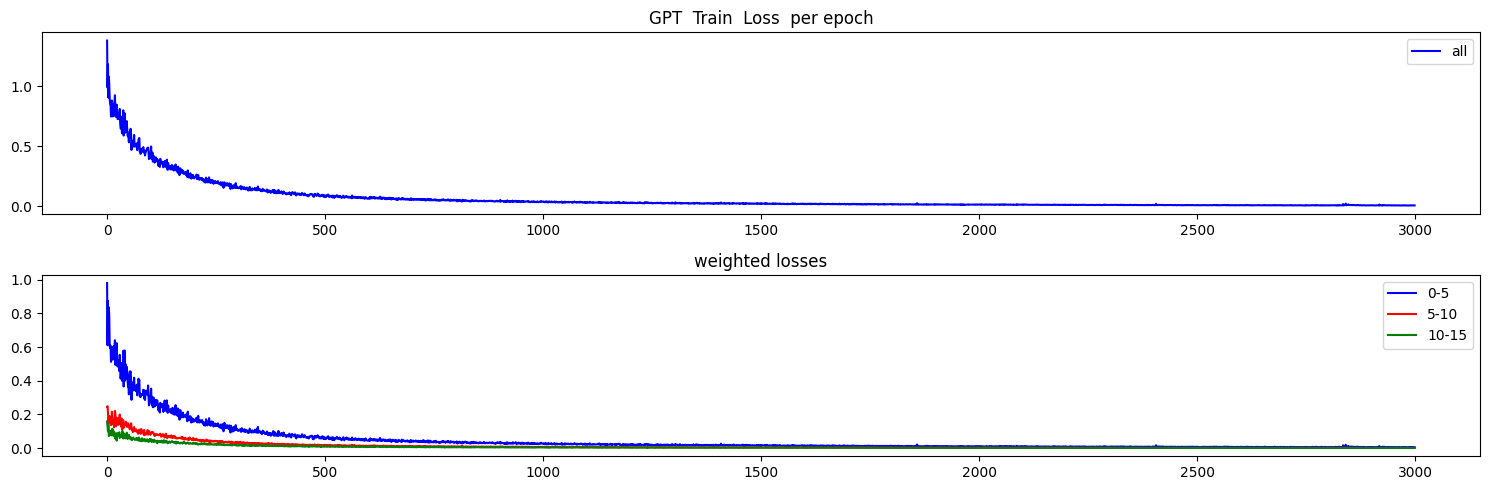

max tokens  14
torch.Size([1, 5, 26])
Test MSE Loss - SI only:  0.17973481118679047
Test MSE Loss - SI only 0-5:  0.10515514761209488
Test MSE Loss - SI only 5-10:  0.42985743284225464
Test MSE Loss - SI only 10-15:  0.07479245215654373
mae, mse, rmse, mape, mspe, rse, corr
(0.31837985, 0.17973481, 0.42395142, 1.7127256, 4.535529, 1.0203017)
Testing R**2 - SI only:  -0.041015554463142756
Testing R**2 - SI only:  -0.041015554463142756
Testing R**2 - All features:  0.5345760646513433
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0


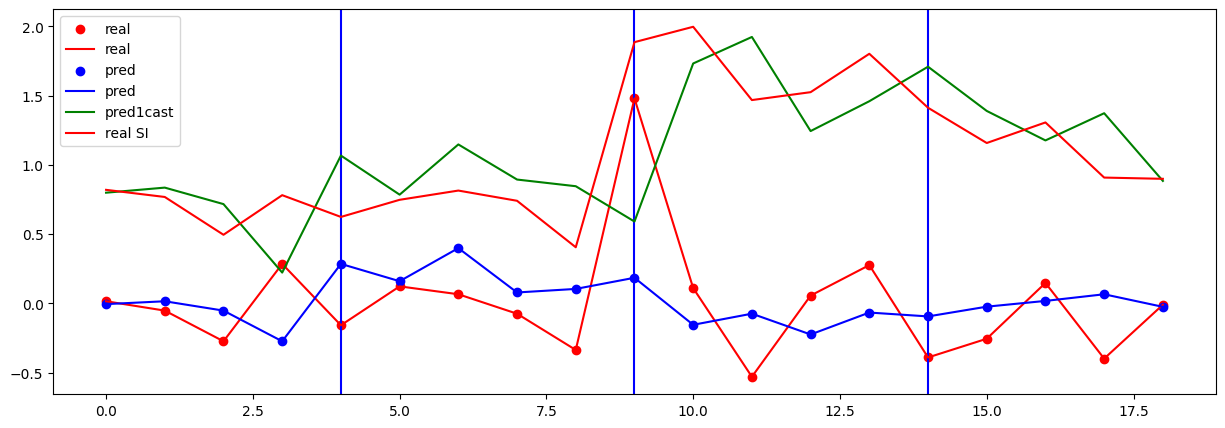

In [60]:

the_offset = 0   ## 0, 15, 30, 45, 60, 75, 90, 105

index_to_slice = 436

index_to_slice = index_to_slice + the_offset

print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]
## sliced_chunk_CIVS

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

print( train_CIVS.shape )
print( test_CIVS.shape )

## test_CIVS 

chunk_slideWind_train = train_CIVS[ :  ] 

print( chunk_slideWind_train.shape )

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk_slideWind_train  )

results_string = function_test_rc(  chunk_slideWind_train, test_CIVS, si_GPT, x_means, x_standard_devs )

results_string = results_string + "," + str( the_offset ) + "," + "SlidWind1" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()

np.savetxt("for_excel_7_window.csv", excel_matrix, delimiter=",")




## 015 to 030


451
571
15
(105, 26)
(15, 26)
(105, 26)
torch.Size([105, 26])
0 train loss =  1.1395797729492188
seq length of pred =  15
500 train loss =  0.07280227541923523
seq length of pred =  15
1000 train loss =  0.025958335027098656
seq length of pred =  15
1500 train loss =  0.018110085278749466
seq length of pred =  15
2000 train loss =  0.011706674471497536
seq length of pred =  15
2500 train loss =  0.008211691863834858
seq length of pred =  15


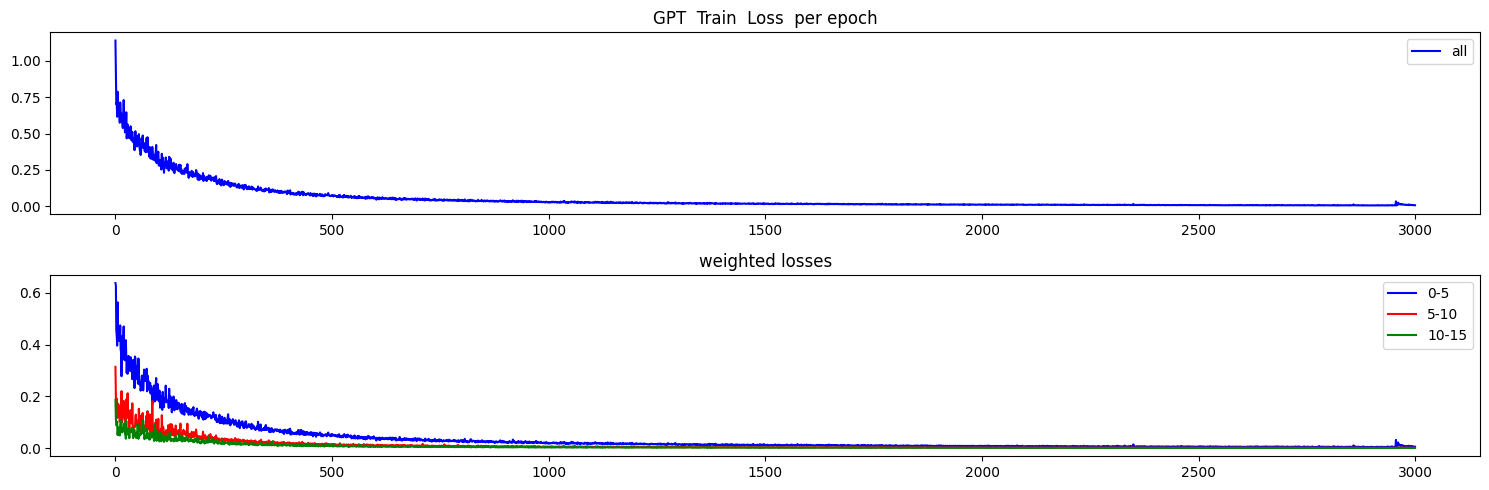

max tokens  14
torch.Size([1, 5, 26])
Test MSE Loss - SI only:  0.048659805208444595
Test MSE Loss - SI only 0-5:  0.036088183522224426
Test MSE Loss - SI only 5-10:  0.017714839428663254
Test MSE Loss - SI only 10-15:  0.005103140138089657
mae, mse, rmse, mape, mspe, rse, corr
(0.16485074, 0.048659805, 0.22058968, 4.044466, 104.008385, 1.4055736)
Testing R**2 - SI only:  -0.9756370918972395
Testing R**2 - SI only:  -0.9756370918972395
Testing R**2 - All features:  0.9435108647253844
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0


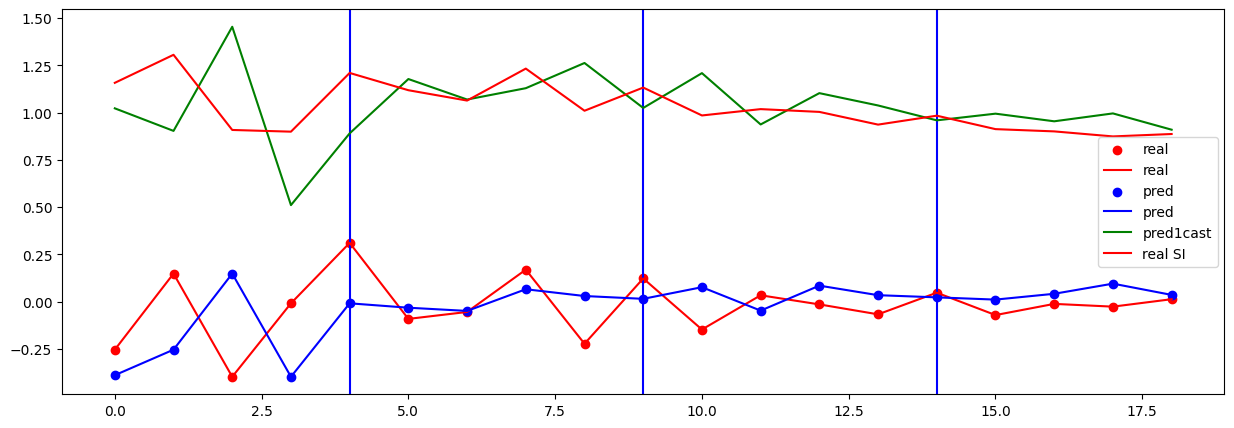

In [61]:

the_offset = 15   ## 0, 15, 30, 45, 60, 75, 90, 105

index_to_slice = 436

index_to_slice = index_to_slice + the_offset

print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]
## sliced_chunk_CIVS

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

print( train_CIVS.shape )
print( test_CIVS.shape )

## test_CIVS 

chunk_slideWind_train = train_CIVS[ :  ] 

print( chunk_slideWind_train.shape )

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk_slideWind_train  )

results_string = function_test_rc(  chunk_slideWind_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + str( the_offset ) + "," + "SlidWind1" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()

np.savetxt("for_excel_7_window.csv", excel_matrix, delimiter=",")



## 030 to 045


466
586
15
(105, 26)
(15, 26)
(105, 26)
torch.Size([105, 26])
0 train loss =  1.4945893287658691
seq length of pred =  15
500 train loss =  0.0935049057006836
seq length of pred =  15
1000 train loss =  0.04233346879482269
seq length of pred =  15
1500 train loss =  0.018919000402092934
seq length of pred =  15
2000 train loss =  0.015024326741695404
seq length of pred =  15
2500 train loss =  0.009411749430000782
seq length of pred =  15


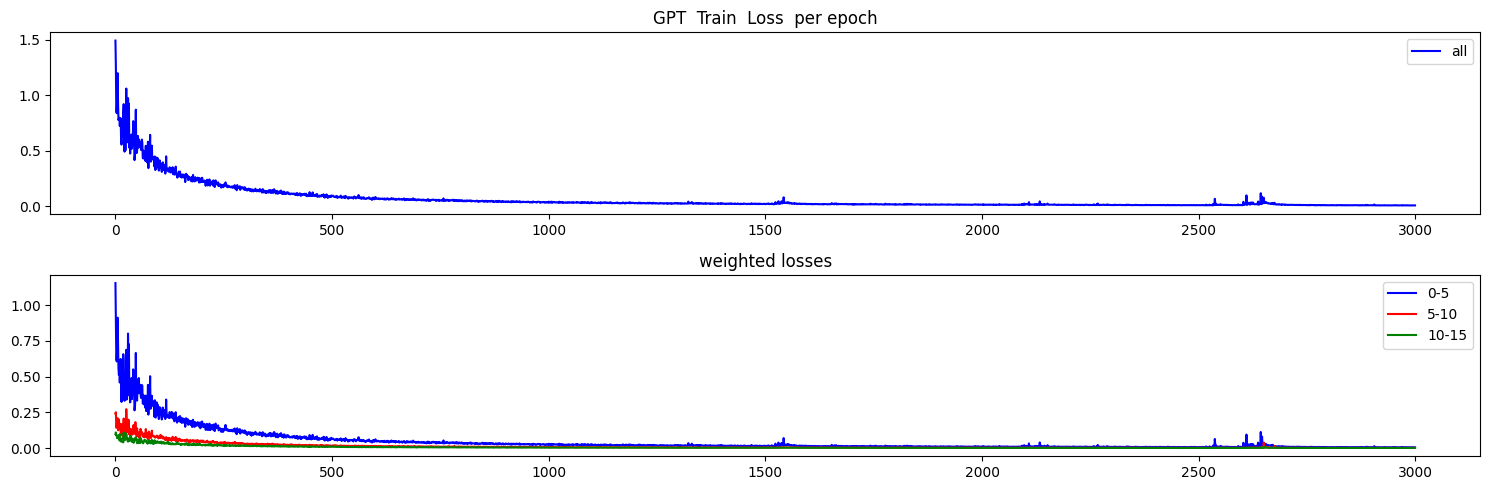

max tokens  14
torch.Size([1, 5, 26])
Test MSE Loss - SI only:  0.08538655191659927
Test MSE Loss - SI only 0-5:  0.12186477333307266
Test MSE Loss - SI only 5-10:  0.1576383411884308
Test MSE Loss - SI only 10-15:  0.04110684245824814
mae, mse, rmse, mape, mspe, rse, corr
(0.22965439, 0.08538656, 0.29220977, 2.1213174, 6.3059664, 1.1954299)
Testing R**2 - SI only:  -0.4290527535713127
Testing R**2 - SI only:  -0.4290527535713127
Testing R**2 - All features:  0.7328413035317323
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0


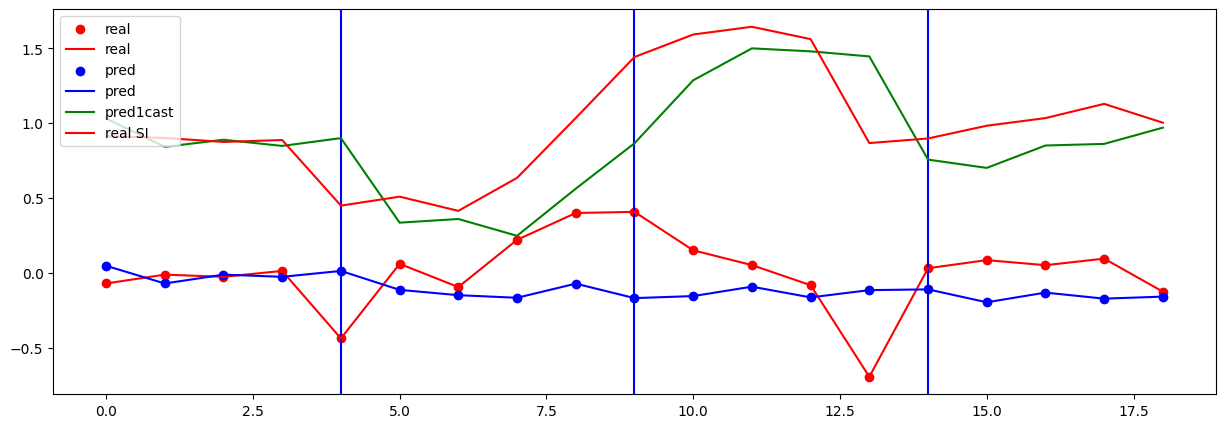

In [62]:

the_offset = 30  ## 0, 15, 30, 45, 60, 75, 90, 105

index_to_slice = 436

index_to_slice = index_to_slice + the_offset

print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]
## sliced_chunk_CIVS

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

print( train_CIVS.shape )
print( test_CIVS.shape )

## test_CIVS 

chunk_slideWind_train = train_CIVS[ :  ] 

print( chunk_slideWind_train.shape )

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk_slideWind_train  )

results_string = function_test_rc(  chunk_slideWind_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + str( the_offset ) + "," + "SlidWind1" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()

np.savetxt("for_excel_7_window.csv", excel_matrix, delimiter=",")



## 045 to 060


481
601
15
(105, 26)
(15, 26)
(105, 26)
torch.Size([105, 26])
0 train loss =  1.1180332899093628
seq length of pred =  15
500 train loss =  0.08206646144390106
seq length of pred =  15
1000 train loss =  0.0338783860206604
seq length of pred =  15
1500 train loss =  0.018923746421933174
seq length of pred =  15
2000 train loss =  0.01151607558131218
seq length of pred =  15
2500 train loss =  0.012753314338624477
seq length of pred =  15


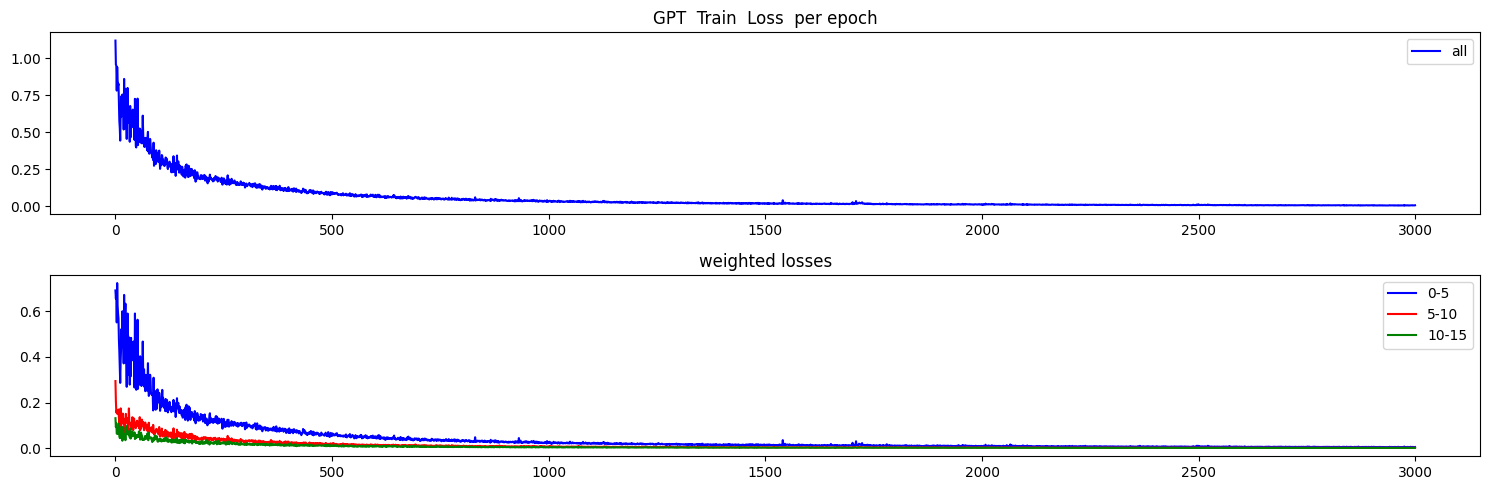

max tokens  14
torch.Size([1, 5, 26])
Test MSE Loss - SI only:  0.03397713601589203
Test MSE Loss - SI only 0-5:  0.039057716727256775
Test MSE Loss - SI only 5-10:  0.03982885554432869
Test MSE Loss - SI only 10-15:  0.039247848093509674
mae, mse, rmse, mape, mspe, rse, corr
(0.15610637, 0.03397714, 0.18432888, 5.8937016, 190.74004, 1.370113)
Testing R**2 - SI only:  -0.8772095409089469
Testing R**2 - SI only:  -0.8772095409089469
Testing R**2 - All features:  0.9045876493742516
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0


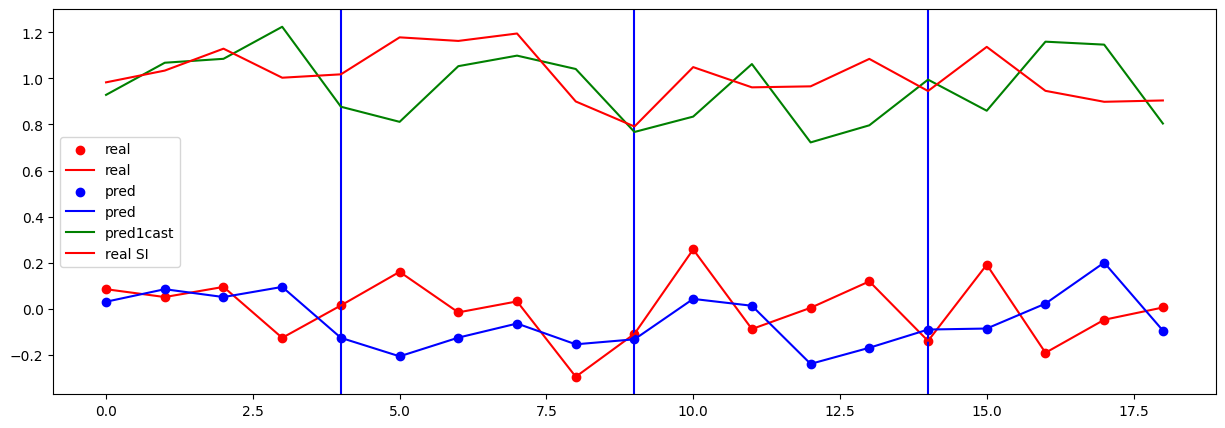

In [63]:

the_offset = 45   ## 0, 15, 30, 45, 60, 75, 90, 105

index_to_slice = 436

index_to_slice = index_to_slice + the_offset

print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]
## sliced_chunk_CIVS

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

print( train_CIVS.shape )
print( test_CIVS.shape )

## test_CIVS 

chunk_slideWind_train = train_CIVS[ :  ] 

print( chunk_slideWind_train.shape )

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk_slideWind_train  )

results_string = function_test_rc(  chunk_slideWind_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + str( the_offset ) + "," + "SlidWind1" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()

np.savetxt("for_excel_7_window.csv", excel_matrix, delimiter=",")



## 060 to 075


496
616
15
(105, 26)
(15, 26)
(105, 26)
torch.Size([105, 26])
0 train loss =  1.0342355966567993
seq length of pred =  15
500 train loss =  0.08191114664077759
seq length of pred =  15
1000 train loss =  0.03338043391704559
seq length of pred =  15
1500 train loss =  0.02066281996667385
seq length of pred =  15
2000 train loss =  0.014635677449405193
seq length of pred =  15
2500 train loss =  0.009392795152962208
seq length of pred =  15


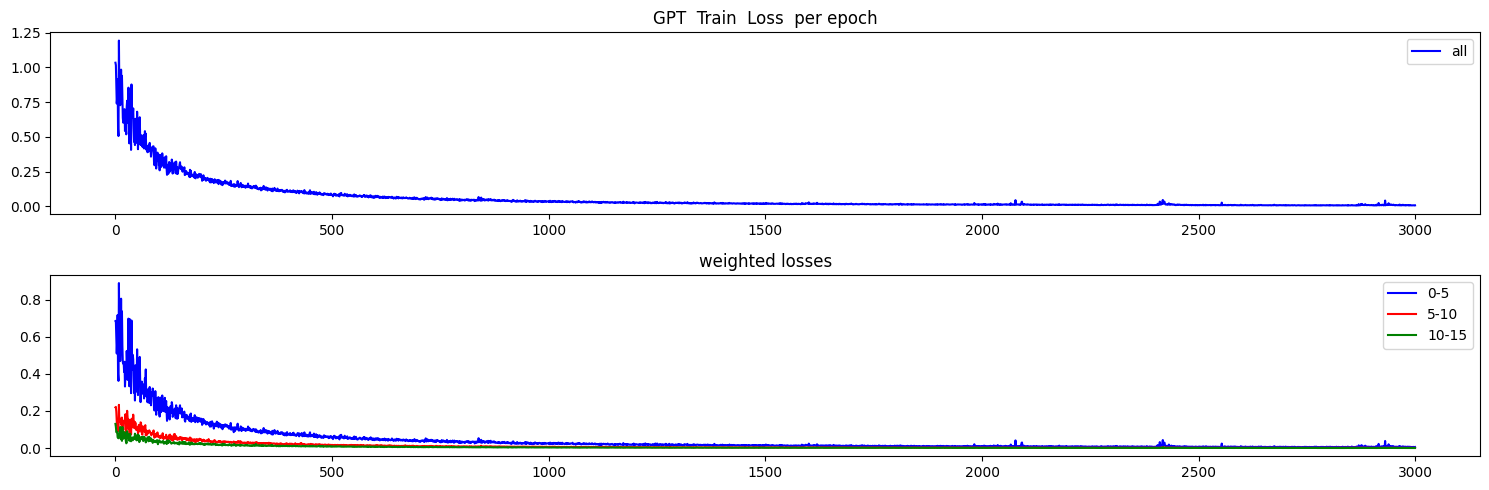

max tokens  14
torch.Size([1, 5, 26])
Test MSE Loss - SI only:  0.04380248859524727
Test MSE Loss - SI only 0-5:  0.05902695655822754
Test MSE Loss - SI only 5-10:  0.011476891115307808
Test MSE Loss - SI only 10-15:  0.0401591882109642
mae, mse, rmse, mape, mspe, rse, corr
(0.17893262, 0.043802485, 0.20929043, 23.253862, 8748.983, 1.3516587)
Testing R**2 - SI only:  -0.8269811922259578
Testing R**2 - SI only:  -0.8269811922259578
Testing R**2 - All features:  0.9923776837178873
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0


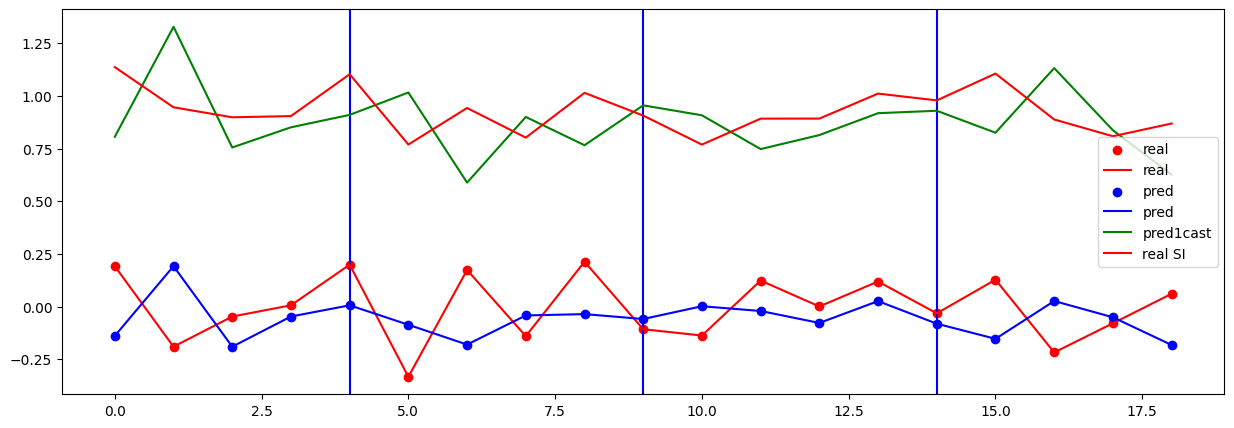

In [64]:

the_offset = 60   ## 0, 15, 30, 45, 60, 75, 90, 105

index_to_slice = 436

index_to_slice = index_to_slice + the_offset

print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]
## sliced_chunk_CIVS

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

print( train_CIVS.shape )
print( test_CIVS.shape )

## test_CIVS 

chunk_slideWind_train = train_CIVS[ :  ] 

print( chunk_slideWind_train.shape )

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk_slideWind_train  )

results_string = function_test_rc(  chunk_slideWind_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + str( the_offset ) + "," + "SlidWind1" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()

np.savetxt("for_excel_7_window.csv", excel_matrix, delimiter=",")



## 075 to 090


511
631
15
(105, 26)
(15, 26)
(105, 26)
torch.Size([105, 26])
0 train loss =  1.020391821861267
seq length of pred =  15
500 train loss =  0.08255404233932495
seq length of pred =  15
1000 train loss =  0.047292403876781464
seq length of pred =  15
1500 train loss =  0.021987080574035645
seq length of pred =  15
2000 train loss =  0.014409546740353107
seq length of pred =  15
2500 train loss =  0.011043057776987553
seq length of pred =  15


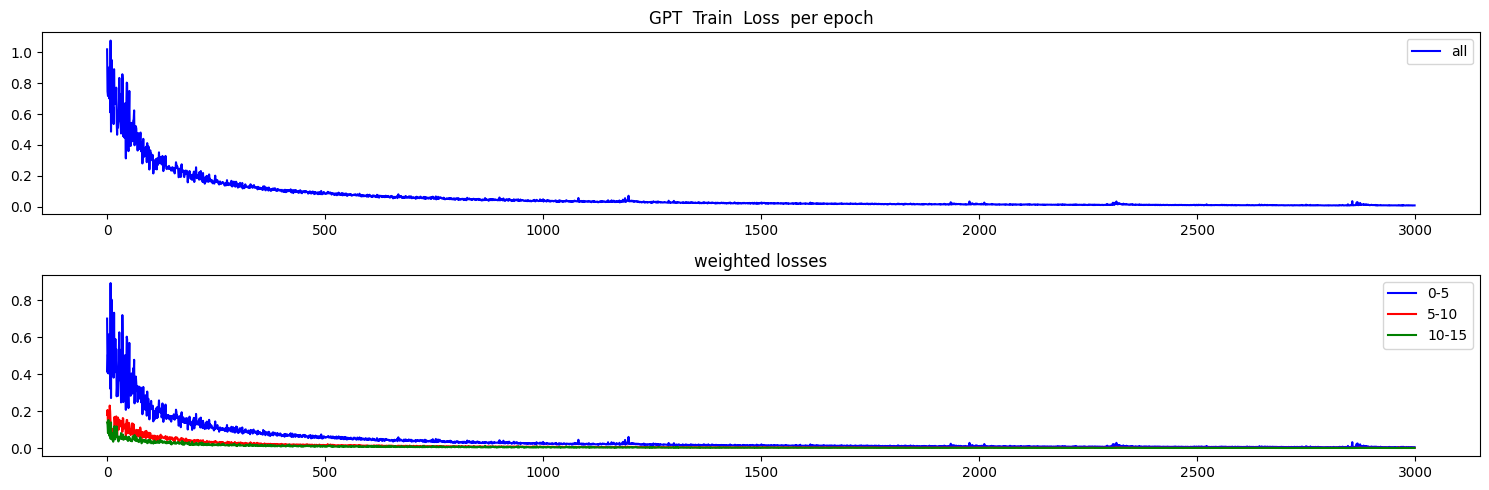

max tokens  14
torch.Size([1, 5, 26])
Test MSE Loss - SI only:  0.03829863667488098
Test MSE Loss - SI only 0-5:  0.02686896361410618
Test MSE Loss - SI only 5-10:  0.06422364711761475
Test MSE Loss - SI only 10-15:  0.017744917422533035
mae, mse, rmse, mape, mspe, rse, corr
(0.16728307, 0.038298637, 0.19570038, 2.738976, 18.33757, 1.3765966)
Testing R**2 - SI only:  -0.8950185693452282
Testing R**2 - SI only:  -0.8950185693452282
Testing R**2 - All features:  0.9614842604386382
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0


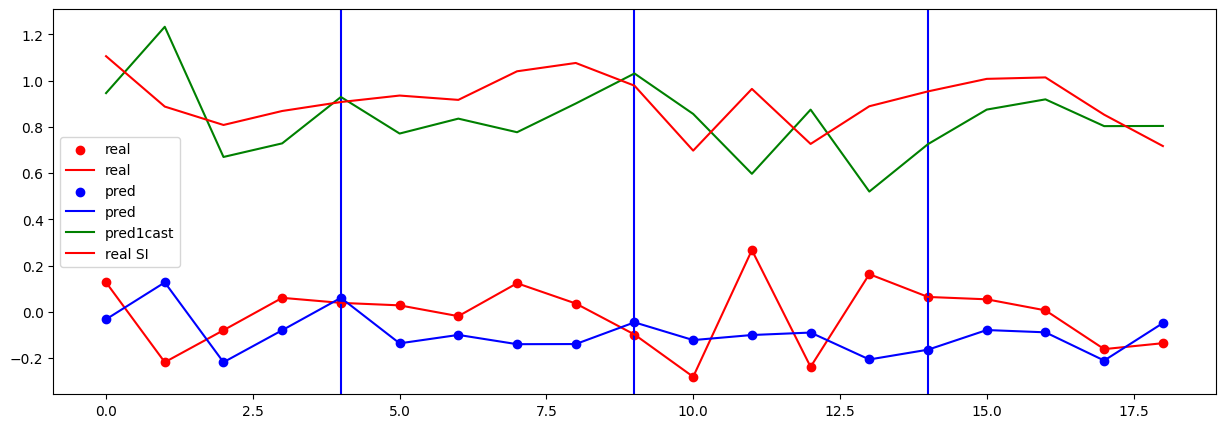

In [65]:

the_offset = 75   ## 0, 15, 30, 45, 60, 75, 90, 105

index_to_slice = 436

index_to_slice = index_to_slice + the_offset

print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]
## sliced_chunk_CIVS

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

print( train_CIVS.shape )
print( test_CIVS.shape )

## test_CIVS 

chunk_slideWind_train = train_CIVS[ :  ] 

print( chunk_slideWind_train.shape )

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk_slideWind_train  )

results_string = function_test_rc(  chunk_slideWind_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + str( the_offset ) + "," + "SlidWind1" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()

np.savetxt("for_excel_7_window.csv", excel_matrix, delimiter=",")



## 090 to 105


526
646
15
(105, 26)
(15, 26)
(105, 26)
torch.Size([105, 26])
0 train loss =  1.0766863822937012
seq length of pred =  15
500 train loss =  0.10015514492988586
seq length of pred =  15
1000 train loss =  0.037162236869335175
seq length of pred =  15
1500 train loss =  0.020961016416549683
seq length of pred =  15
2000 train loss =  0.014996949583292007
seq length of pred =  15
2500 train loss =  0.009830581024289131
seq length of pred =  15


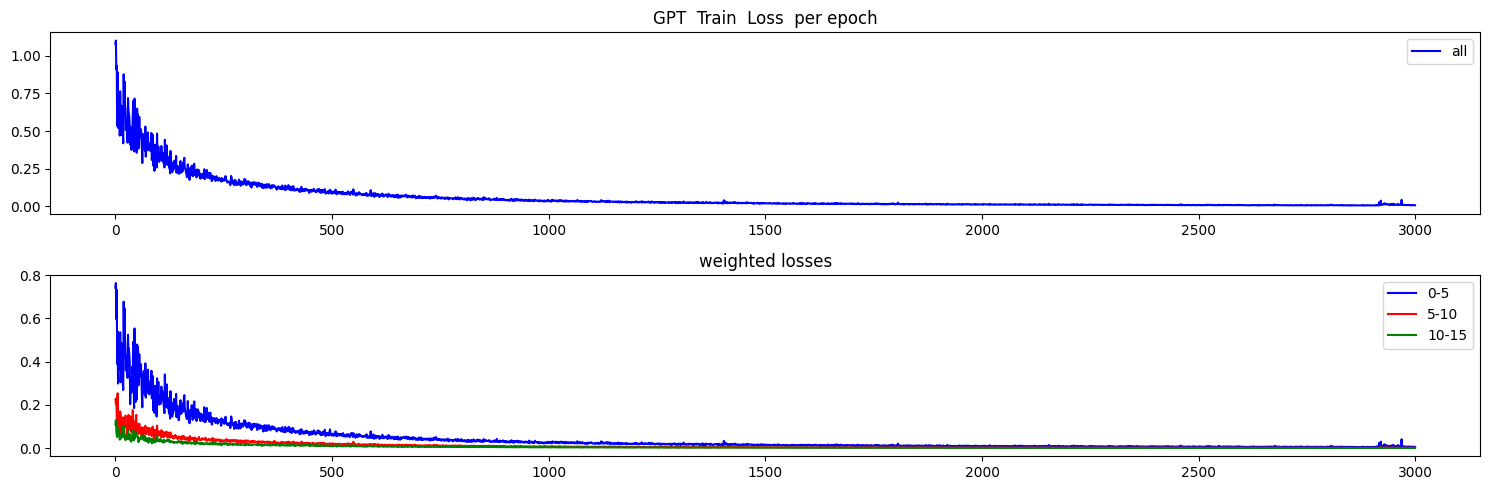

max tokens  14
torch.Size([1, 5, 26])
Test MSE Loss - SI only:  0.04350758716464043
Test MSE Loss - SI only 0-5:  0.02977134846150875
Test MSE Loss - SI only 5-10:  0.09686443954706192
Test MSE Loss - SI only 10-15:  0.03246298432350159
mae, mse, rmse, mape, mspe, rse, corr
(0.17386699, 0.043507587, 0.20858473, 5.31828, 220.21803, 1.2480484)
Testing R**2 - SI only:  -0.5576249058378058
Testing R**2 - SI only:  -0.5576249058378058
Testing R**2 - All features:  0.9577076685001686
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0


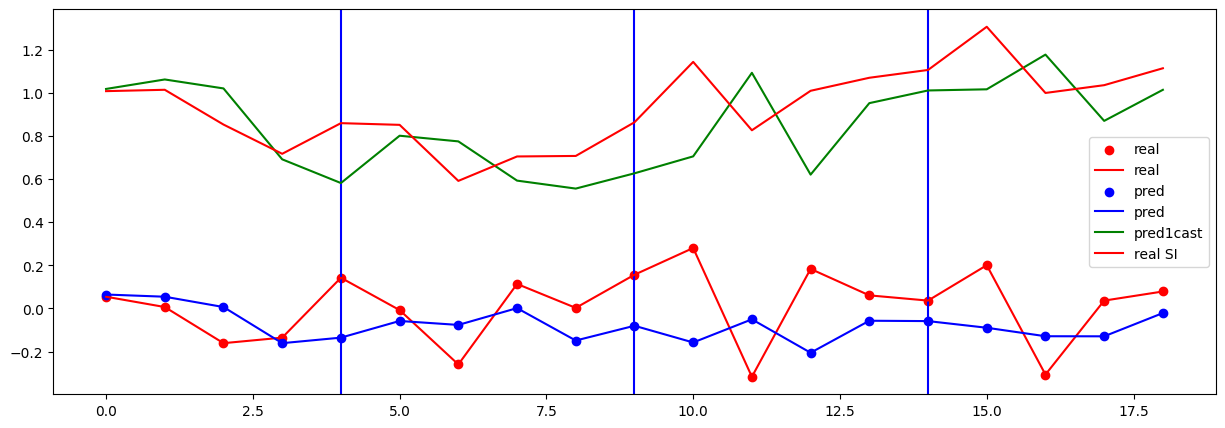

In [66]:

the_offset = 90   ## 0, 15, 30, 45, 60, 75, 90, 105

index_to_slice = 436

index_to_slice = index_to_slice + the_offset

print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]
## sliced_chunk_CIVS

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

print( train_CIVS.shape )
print( test_CIVS.shape )

## test_CIVS 

chunk_slideWind_train = train_CIVS[ :  ] 

print( chunk_slideWind_train.shape )

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk_slideWind_train  )

results_string = function_test_rc(  chunk_slideWind_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + str( the_offset ) + "," + "SlidWind1" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()

excel_matrix = np.round(excel_matrix, 2)
np.savetxt("for_excel_7_window.csv", excel_matrix, delimiter=",")



## Add the dates ( ??) 


In [67]:

index_to_slice    = 436

sliced_chunk_DATES_MAP = df_Dates_Map[ index_to_slice : index_to_slice + 250]['Date_Map']
sliced_chunk_DATES_MAP



436    2021-09-01 17:11:00
437    2021-09-01 18:40:00
438    2021-09-02 00:15:00
439    2021-09-02 02:57:00
440    2021-09-02 05:05:00
              ...         
681    2021-09-28 00:39:00
682    2021-09-29 00:55:00
683    2021-09-29 04:44:00
684    2021-09-29 07:19:00
685    2021-09-29 09:53:00
Name: Date_Map, Length: 250, dtype: object

In [68]:

sliced_chunk_DATES_MAP_np = sliced_chunk_DATES_MAP.to_numpy()

sliced_chunk_DATES_MAP_np = np.expand_dims(sliced_chunk_DATES_MAP_np, axis=1)


sliced_chunk_DATES_MAP_np.shape



(250, 1)

In [69]:

excel_matrix.shape


(250, 30)

In [70]:

## excel_matrix = np.concatenate((sliced_chunk_DATES_MAP_np, excel_matrix), axis=1)   ## add this back for dates

excel_matrix.shape


(250, 30)

In [71]:

excel_matrix_pd = pd.DataFrame(excel_matrix)


In [72]:

excel_matrix_pd


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.02,-0.00,0.82,0.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.05,0.02,0.77,0.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.27,-0.05,0.50,0.72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.29,-0.27,0.78,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.16,0.29,0.62,1.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:

excel_matrix_pd.to_csv("for_excel_7_window.csv")
    
## np.savetxt("for_excel_7_window.csv", excel_matrix, delimiter=",")


In [74]:
## DrZhao


## Write to file


In [75]:

line = 'id, delta_real,delta_pred,DrZ_real,DrZ_pred,delta_real,delta_pred,DrZ_real,DrZ_pred,delta_real,delta_pred,DrZ_real,DrZ_pred,'
line = line + 'delta_real,delta_pred,DrZ_real,DrZ_pred,delta_real,delta_pred,DrZ_real,DrZ_pred,delta_real,delta_pred,DrZ_real,DrZ_pred,'
line = line + 'delta_real,delta_pred,DrZ_real,DrZ_pred,None,None'
with open("for_excel_7_window.csv", 'r+') as file: 
 file_data = file.read() 
 file.seek(0, 0) 
 file.write(line + '\n' + file_data)
file.close()



## Start of the 6 Random Runs



## Pick slice randomly


In [ ]:

training_chunk = 400


In [ ]:

length_n  = int( for_RNN_data_CIVS.shape[0] )

length_n



## Run 1


In [ ]:
from datetime import datetime

the_range = training_chunk + block_size

## random.seed()        ## RC
random.seed( datetime.now().timestamp() )

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice


In [ ]:

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )


In [ ]:

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]


In [ ]:

sliced_chunk_CIVS



## Train and test


In [ ]:

n = block_size

print( n )


In [ ]:

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]


In [ ]:

print( train_CIVS.shape )
print( test_CIVS.shape )


In [ ]:

test_CIVS 


In [ ]:

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


In [ ]:

print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


In [ ]:
'''
print(idx.shape)
        vals, indeces = torch.max( idx, dim=2  )
        print( vals.shape )
        print( indeces )
        print(idx.shape)
        input()
'''

In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 2


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ]  


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )





In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 3


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string  = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 4


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



## Run 5


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 6


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()
